# Laboratorium 11 - Optymalizacja
## Błażej Naziemiec i Szymon Żuk
### 17 czerwca 2025
## Wstęp
W tym laboratorium zajmiemy się optymalizacją kosztu obliczeń funkcji. W tym celu wykonamy dwa zadania. Pierwsze z nich polega na porównaniu rozwiązania problemu predykcji typu komórek nowotworowych za pomocą metody najmniejszych kwadratów oraz regresje liniową. W drugim zadaniu musimy stworzyć algorytm, który jak najmniejszym kosztem znajdzie ścieżkę dla robota z punktu startowego do punktu końcowego.

## Zadanie 1
Na początku zaimportowaliśmy dane odnośnie komórek nowotowrowych, które otrzymaliśmy w laboratorium 2. Następnie skopiowaliśmy kod z laba 2 do wyznaczania predykcji metodą najmniejszych kwadratów. Następnie zaimplementowaliśmy funkcję rozwiązującą ten problem metodą spadku wzdłuż gradientu. Przyjęliśmy $\alpha = \frac{1}{\lambda_{\text{max}} + \lambda_{\text{min}}}$, gdzie $\lambda$ to wartość własna macierzy $A^T * A$. Gradient $\nabla f(x_k)$ obliczyliśmy ze wzoru $2A^T(Ax - b)$. Wyniki oraz czasy wykonania przedstawiliśmy poniżej.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from time import time

In [17]:
with open("dataset/breast-cancer.labels", "r") as f:
    labels = [line.strip() for line in f.readlines()]
train_data = pd.io.parsers.read_csv("dataset/breast-cancer-train.dat", names=labels)
validate_data = pd.io.parsers.read_csv("dataset/breast-cancer-validate.dat", names=labels)
train_data_malignant = train_data[train_data["Malignant/Benign"] == "M"]
train_data_benign = train_data[train_data["Malignant/Benign"] == "B"]

In [18]:
def least_square():
    linear_train = train_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
    linear_validate = validate_data.drop(["patient ID", "Malignant/Benign"], axis=1).values

    def create_quadratic_representation(data):
        df = data.copy()
        for i in range(len(quad_columns)):
            df[f"{i}^2"] = data[quad_columns[i]] ** 2
        for i in range(len(quad_columns)):
            for j in range(i + 1, len(quad_columns)):
                df[f"{i}_{j}"] = data[quad_columns[i]] * data[quad_columns[j]]
        return df.values

    quad_columns = ["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]
    quadratic_train = create_quadratic_representation(train_data[quad_columns])
    quadratic_validate = create_quadratic_representation(validate_data[quad_columns])

    b_training = np.where(train_data[['Malignant/Benign']] == "M", 1, -1)
    b_validate = np.where(validate_data[['Malignant/Benign']] == "M", 1, -1)

    cov_mat_lin = linear_train.T @ linear_train
    cov_mat_quad = quadratic_train.T @ quadratic_train

    weights_linear = np.linalg.solve(cov_mat_lin, linear_train.T @ b_training)
    weights_quadratic = np.linalg.solve(cov_mat_quad, quadratic_train.T @ b_training)

    λ = 0.01
    svd = scipy.linalg.lstsq(cov_mat_lin + λ * np.eye(cov_mat_lin.shape[0]), linear_train.T @ b_training)

    p_lin = linear_validate @ weights_linear
    p_quad = quadratic_validate @ weights_quadratic
    p_lambda = linear_validate @ weights_linear
    p_svd = linear_validate @ svd[0]
    def calc_acc(p_vec, b_vec):
        tp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b > 0])
        tn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b < 0])
        fp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b <= 0])
        fn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b > 0])
        return int(tp), int(tn), int(fp), int(fn), float((tp + tn) / (tp + tn + fp + fn))

    tp_lin, tn_lin, fp_lin, fn_lin, acc_lin = calc_acc(p_lin, b_validate)
    tp_quad, tn_quad, fp_quad, fn_quad, acc_quad = calc_acc(p_quad, b_validate)
    tp_lambda, tn_lambda, fp_lambda, fn_lambda, acc_lambda = calc_acc(p_lambda, b_validate)
    tp_svd, tn_svd, fp_svd, fn_svd, acc_svd = calc_acc(p_svd, b_validate)
    return (tp_lin, tn_lin, fp_lin, fn_lin, acc_lin), (tp_quad, tn_quad, fp_quad, fn_quad, acc_quad), (tp_lambda, tn_lambda, fp_lambda, fn_lambda, acc_lambda),(tp_svd, tn_svd, fp_svd, fn_svd, acc_svd)

In [19]:
def gradient_descent(eps=0.0001, n_iterations=100000):
    A = train_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
    A = np.c_[np.ones(A.shape[0]), A]

    A_validate = validate_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
    A_validate = np.c_[np.ones(A_validate.shape[0]), A_validate]

    b = np.where(train_data[['Malignant/Benign']] == "M", 1, -1)
    b_validate = np.where(validate_data[['Malignant/Benign']] == "M", 1, -1)
    
    b = b.flatten()

    AtA = A.T @ A

    eigv = scipy.linalg.eigvals(AtA)
    real_eigv = np.real(eigv)

    lambda_max = np.max(real_eigv)
    lambda_min = np.min(real_eigv)

    alpha = 1 / (lambda_max + lambda_min)
    
    def calc_gradient(A, x, b):
        return 2 * A.T @ (A @ x - b)
    
    n_samples, n_features = A.shape
    
    x = np.zeros(n_features)
    
    k = 1
    
    while k < n_iterations:
        x_next = x - alpha * calc_gradient(A, x, b)
        if np.linalg.norm(x_next - x) < eps:
            break
        x = x_next
        k += 1
        
    p = A_validate @ x

    def calc_acc(p_vec, b_vec):
        tp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b > 0])
        tn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b < 0])
        fp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b <= 0])
        fn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b > 0])
        total = tp + tn + fp + fn
        accuracy = float((tp + tn) / total) if total > 0 else 0.0
        return int(tp), int(tn), int(fp), int(fn), accuracy

    tp, tn, fp, fn, accuracy = calc_acc(p, b_validate.flatten())

    return (tp, tn, fp, fn, accuracy), k

In [20]:
print("Wyniki otrzymane z kodu z laboratorium 2:")
start_time = time()
least_square_results = least_square()
end_time = time()
print(f"Czas wykonania: {end_time - start_time:.4f} sekund")
least_square_results

Wyniki otrzymane z kodu z laboratorium 2:
Czas wykonania: 0.0566 sekund


((58, 194, 6, 2, 0.9692307692307692),
 (55, 185, 15, 5, 0.9230769230769231),
 (58, 194, 6, 2, 0.9692307692307692),
 (55, 199, 1, 5, 0.9769230769230769))

| Rodzaj metody | true positive | true negative | false positive | false negative | accuracy |
|---------------|---------------|----------------|-----------------|-----------------|----------|
| Liniowa       | 58           | 194            | 6             | 2             | 96.92%      |
| Kwadratowa    | 55           | 185            | 15             | 5             | 92.31%      |
| Lambda        | 58           | 194            | 6             | 2             | 96.92%      |
| SVD           | 55           | 199            | 1             | 5             | 97.69%      |

*Tabela 1. Wyniki predykcji typu komórek nowotworowych dla różnych macierzy metody najmniejszych kwadratów*

Analizując wyniki z tabeli 1 możemy zauważyć, że najlepsze wyniki uzyskaliśmy dla macierzy SVD i jego dokładność wynosi 97.69%. Następnie wykonaliśmy operację regresji liniowej dla tych samych danych, a wyniki przedstawiliśmy w tabeli 2.

In [21]:
start_time = time()
grad_result, grad_iterations = gradient_descent()
print("Wyniki otrzymane z gradientu:")
end_time = time()
print(f"Czas wykonania: {end_time - start_time:.4f} sekund")
grad_result, grad_iterations

Wyniki otrzymane z gradientu:
Czas wykonania: 3.5047 sekund


((58, 177, 23, 2, 0.9038461538461539), 100000)

| true positive | true negative | false positive | false negative | accuracy | liczba iteracji |
|---------------|----------------|-----------------|-----------------|----------|-----------------|
| 58            | 177            | 23               | 2               | 90.38%   | 100000           |

*Tabela 2. Wyniki spadku wzdłuż gradientu dla danych komórek nowotworowych*
  

Z tabeli 2 wynika, że dokładność wynosi 90.38%, co jest gorszym wynikiem niż w przypadku metody najmniejszych kwadratów dla każdego typu macierzy. W związku z tym możemy stwierdzić, że metoda najmniejszych kwadratów jest lepsza w tym przypadku. Warto również zwrócić uwagę na teoretyczne złożoności czasowe obu rozwiązań. Metoda najmniejszych kwadratów ma teorytyczną złożoność obliczeniową $O(nm^2+m^3)$, a spadek wzdłuż gradientu $O(nmlog(eps))$. W praktyce metoda najmniejszych kwadratów była znacznie szybsza, pomimo tego, że obliczono w niej wynik na 4 różne sposoby.


## Zadanie 2


Zaimplementowaliśmy funkcję kosztu i funkcję obliczającą gradient funkcji kosztu. Następnie zainicjalizowaliśmy dane początkowe. Macierze $X$ i $R$ wypełniliśmy danymi z rozkładu normalnego za pomocą funkcji $numpy.random.uniform$. Potem zaimplementowaliśmy funkcję minimalizującą koszt metodą spadku wzdłuż gradientu. W implementacji wykorzystaliśmy funkcję $scipy.optimize.golden$ do przeszukiwania liniowego metodą złotego podziału. Potem utworzyliśmy wykresy otrzymanych wartości funkcji kosztu oraz macierzy $X$ i $R$.

Podpunkt 1). Wyznaczenie $\nabla F = [\frac{\partial{F}}{\partial{\mathbf{x}_0}}, ..., \frac{\partial{F}}{\partial{\mathbf{x}_n}}]$

$F(\mathbf{x}) = \lambda_1 \sum_{i=0}^{n-1} \sum_{j=1}^{k-1} \frac{1}{\epsilon + ||\mathbf{x}_i - \mathbf{r}_j||^2} + \lambda_2 \sum_{i=0}^{n-1} ||\mathbf{x}_{i+1} - \mathbf{x}_i||^2$

$\nabla F(\mathbf{x}) = \left[ \frac{\partial F}{\partial \mathbf{x}_0}, \frac{\partial F}{\partial \mathbf{x}_1}, \ldots, \frac{\partial F}{\partial \mathbf{x}_n} \right]$

$F(\mathbf{x}) = F_1(\mathbf{x}) + F_2(\mathbf{x})$

$F_1(\mathbf{x}) = \lambda_1 \sum_{i=0}^{n-1} \sum_{j=1}^{k-1} \frac{1}{\epsilon + ||\mathbf{x}_i - \mathbf{r}_j||^2}$

$F_2(\mathbf{x}) = \lambda_2 \sum_{i=0}^{n-1} ||\mathbf{x}_{i+1} - \mathbf{x}_i||^2$

$\frac{\partial}{\partial \mathbf{x}_t} \left( \frac{1}{\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2} \right) = - \frac{1}{(\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2)^2} \cdot 2(\mathbf{x}_t - \mathbf{r}_j)$

$\frac{\partial F_1}{\partial \mathbf{x}_t} = -2 \lambda_1 \sum_{j=1}^{k-1} \frac{\mathbf{x}_t - \mathbf{r}_j}{(\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2)^2}$

$\frac{\partial}{\partial \mathbf{x}_t} ||\mathbf{x}_{t+1} - \mathbf{x}_t||^2 = -2(\mathbf{x}_{t+1} - \mathbf{x}_t)$

$\frac{\partial}{\partial \mathbf{x}_t} ||\mathbf{x}_{t} - \mathbf{x}_{t-1}||^2 = 2(\mathbf{x}_{t} - \mathbf{x}_{t-1})$

$\frac{\partial F_2}{\partial \mathbf{x}_t} = 2 \lambda_2 \left( (\mathbf{x}_t - \mathbf{x}_{t-1}) - (\mathbf{x}_{t+1} - \mathbf{x}_t) \right) = 2 \lambda_2 \left(2 \mathbf{x}_t - \mathbf{x}_{t - 1} - \mathbf{x}_{t + 1}\right)$

$\frac{\partial F}{\partial \mathbf{x}_t} = -2 \lambda_1 \sum_{j=1}^{k-1} \frac{\mathbf{x}_t - \mathbf{r}_j}{(\epsilon + ||\mathbf{x}_t - \mathbf{r}_j||^2)^2} + 2 \lambda_2 \left(\mathbf{x}_t - \mathbf{x}_{t - 1} - \mathbf{x}_{t + 1} \right)$ dla $t = 1, 2, \ldots, n-1$

In [22]:
import numpy as np
from scipy.optimize import golden
from matplotlib import pyplot as plt

In [23]:
np.random.seed(7)

In [24]:
def calc_F(x, r, n, k, lambda1, lambda2, eps=1e-9):
    sum1 = 0
    for i in range(n):
        for j in range(1, k):
            norm = np.linalg.norm(x[i] - r[j])
            sum1 += 1 / (eps + norm**2)   
    
    sum2 = 0
    for i in range(n):
        sum2 += np.linalg.norm(x[i + 1] - x[i])**2
    
    return lambda1 * sum1 + lambda2 * sum2

In [25]:
def calc_F_grad(x, r, n, k, lambda1, lambda2, eps=1e-9):
    result = np.zeros((n + 1, 2), dtype=np.float64)
    for t in range(1, n):
        sum_ = 0
        for j in range(k):
            denom = (eps + np.linalg.norm(x[t] - r[j])**2)**2
            sum_ += (x[t] - r[j]) / denom
        
        diff1 = x[t] - x[t - 1] 
        diff2 = x[t + 1] - x[t]
        
        val = -2 * lambda1 * sum_ + 2 * lambda2 * (diff1 - diff2)
        
        result[t][0] = val[0]
        result[t][1] = val[1]
        
    return result

In [26]:
def init_x(n, x0, xn):
    x = np.random.uniform(low=0, high=20, size=(n + 1, 2))
    x[0][0] = x0[0]
    x[0][1] = x0[1]
    x[n][0] = xn[0]
    x[n][1] = xn[1]
    return x

def init_r(k):
    return np.random.uniform(low=0, high=20, size=(k, 2))

Podpunkt 2). Algorytm rozpoczynamy od zainicjalizowania punktów wartościami z początkowego przedziału, z ustalonymi punktami początkowym i końcowym. Następnie, w każdej iteracji, obliczany jest gradient funkcji kosztu, który wskazuje kierunek największego spadku kosztu. Potem znajdujemy optymalną długość kroku wzdłuż kierunku gradientu, za pomocą metody złotego podziału, minimalizując funkcję kosztu. Wyznaczona długość kroku jest następnie używana do aktualizacji pozycji wszystkich punktów na ścieżce, z wyjątkiem punktów początkowego i końcowego, które pozostają niezmienne. Proces ten powtarza się przez określoną liczbę iteracji lub do momentu, gdy poprawa kosztu spadnie poniżej ustalonego progu tolerancji.

In [27]:
def minimize_path(n, k, r, x0, xn, lambda1, lambda2, eps, n_iter):
    x = init_x(n, x0, xn)
    
    F = lambda x: calc_F(x, r, n, k, lambda1, lambda2, eps)
    F_grad = lambda x: calc_F_grad(x, r, n, k, lambda1, lambda2, eps)
    
    costs = [F(x)]
    for iter in range(n_iter):
        grad = F_grad(x)
        gold_result = golden(lambda alpha: F(x + alpha * grad))
        x += gold_result * grad
        costs.append(F(x))
        if np.abs(costs[-2] - costs[-1]) < eps:
            break
    return x, r, costs

In [28]:
r_vec = init_r(50)

results = [minimize_path(20, 50, r_vec, [0, 0], [20, 20], 1, 1, 10e-13, 200) for _ in range(5)]

Podpunkt 3). Wyniki działania algorytmu

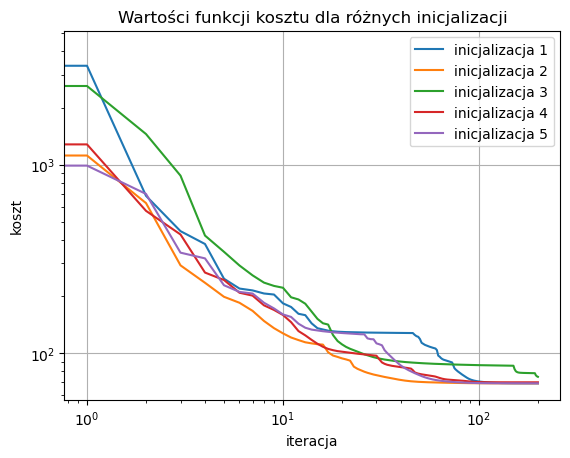

In [29]:
arange = np.arange(0, 401, 1)
plt.loglog(figsize=(12,6))
plt.title("Wartości funkcji kosztu dla różnych inicjalizacji")
plt.xlabel("iteracja")
plt.ylabel("koszt")
for i, result in enumerate(results):
    plt.plot(arange[:len(result[2])], result[2], label=f"inicjalizacja {i + 1}")
plt.legend()
plt.grid()
plt.show()

*Wykres 1. Wartości funkcji kosztu dla różnych inicjalizacji*
 

Jak widać na wykresie wartości funkcji kosztu maleją w podobny sposób dla każej inicjalizacji. Początkowa losowa wartość macierzy X daje koszt większy niż 1000. Koszt ten ostatecznie spada poniżej 100.

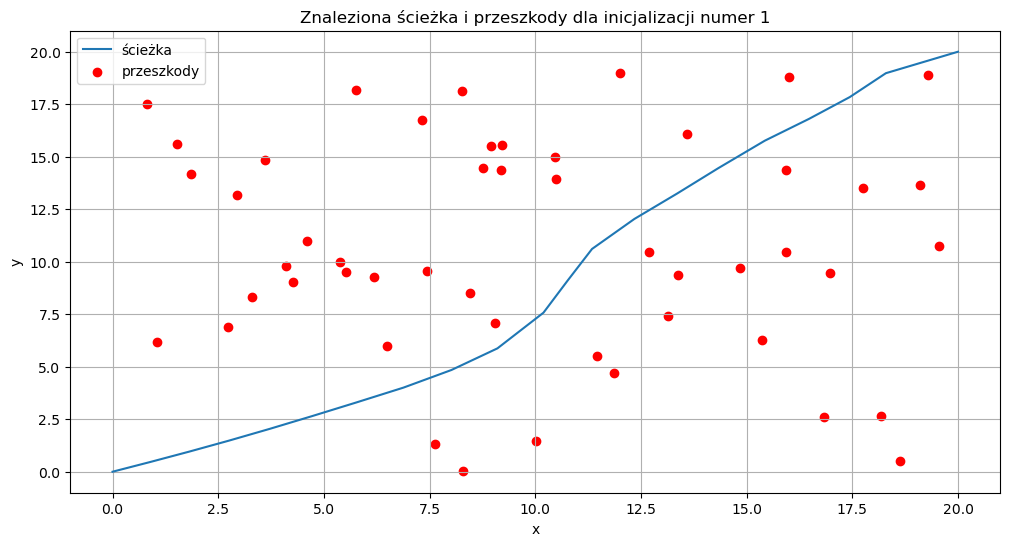

Wykres 2: Znaleziona ścieżka i przeszkody dla inicjalizacji numer 1


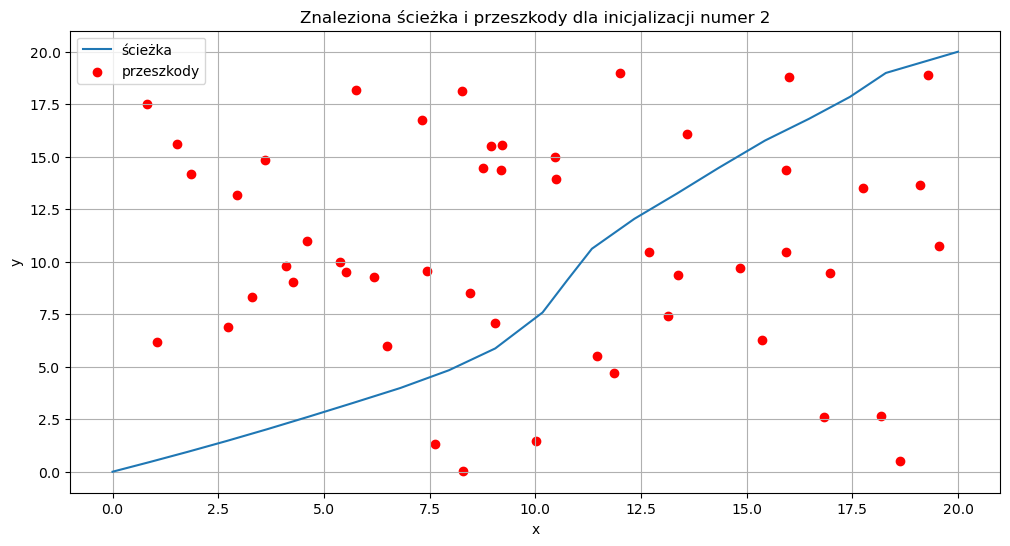

Wykres 3: Znaleziona ścieżka i przeszkody dla inicjalizacji numer 2


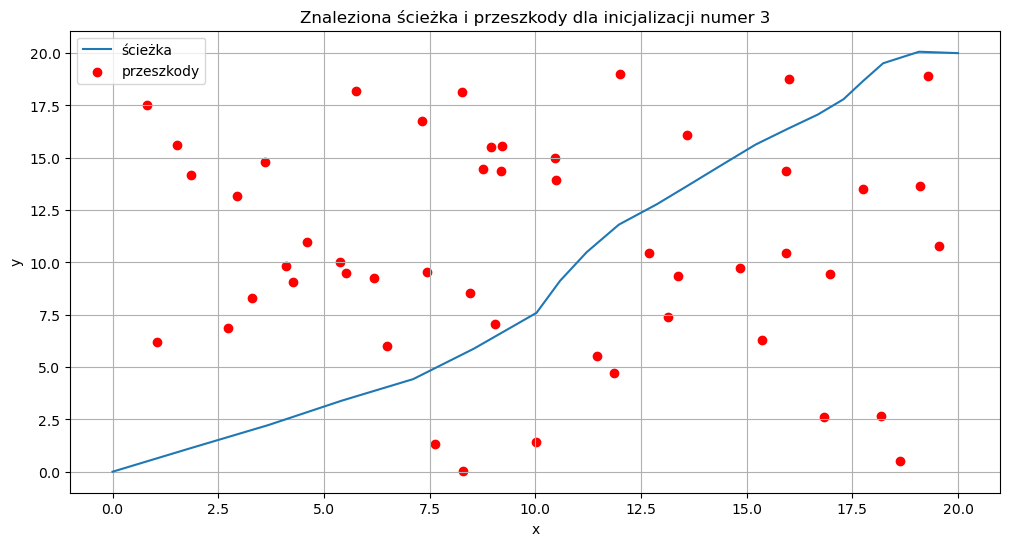

Wykres 4: Znaleziona ścieżka i przeszkody dla inicjalizacji numer 3


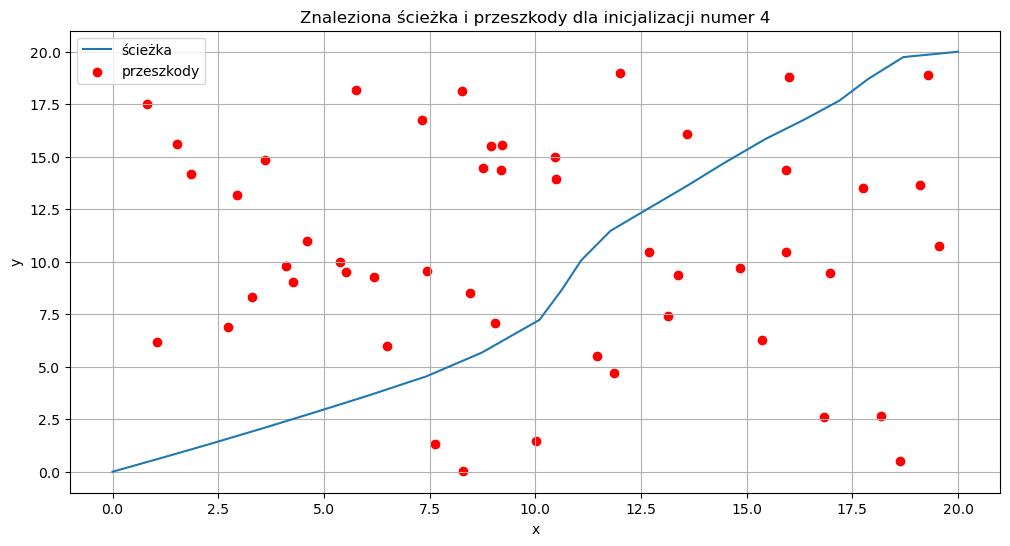

Wykres 5: Znaleziona ścieżka i przeszkody dla inicjalizacji numer 4


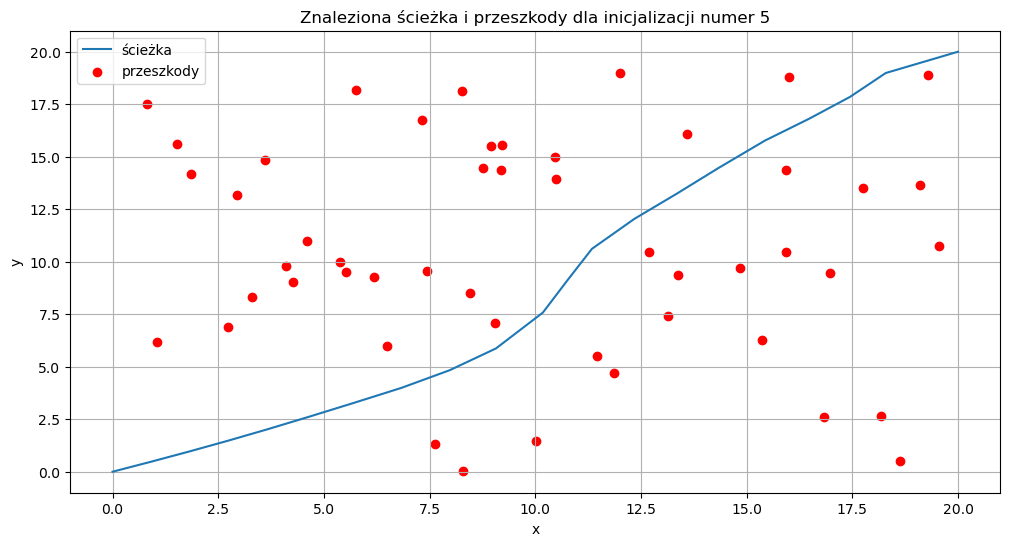

Wykres 6: Znaleziona ścieżka i przeszkody dla inicjalizacji numer 5


In [31]:
def draw(xs, rs, i):
    plt.figure(figsize=(12,6))
    plt.title(f"Znaleziona ścieżka i przeszkody dla inicjalizacji numer {i}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(xs[:,0], xs[:,1], label="ścieżka")
    plt.scatter(rs[:,0], rs[:,1], label="przeszkody", color="red")
    plt.legend()
    plt.grid()
    plt.show()

for i in range(len(results)):
    draw(results[i][0], results[i][1], i + 1)
    print(f"Wykres {i + 2}: Znaleziona ścieżka i przeszkody dla inicjalizacji numer {i + 1}")

Jak widać na wykresach, otrzymane ścieżki nieznacznie różnią się w zależności od inicjalizacji macierzy X i są optymalne. Pokazuje to efektywność algorytmu spadku wzdłuż gradientu.

Podsumowując algorytm spadku wzdłuż gradientu jest efektywną metodą optymalizacji. W pierwszym zadaniu okazał się on mniej dokładny i wolniejszy od metody najmniejszych kwadratów, lecz dał w miarę akceptowalne wyniki. W drugim zadaniu algorytm dał bardzo optymalne wyniki niezależnie od punktu startowego.

## Bibliografia

 - Materiały zamieszczone na platformie Microsoft Teams w zespole $\textit{MOwNiT 2025}$ w zakładce $\textit{Materiały z zajęć/lab11/lab11-intro.pdf}$